# Visualized AIMD EXAFS from FEFF calculations of Zn-doped hematite
Data courtesy of Micah Prange and Eugene Ilton from PNNL

In [15]:
import utils
import wavelet_transform
from importlib import reload
from PIL import Image
from ipywidgets import *
import umap
import itertools

from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.signal.windows import hann, general_hamming
from matplotlib.animation import FuncAnimation, PillowWriter

utils = reload(utils)
wavelet_transform = reload(wavelet_transform)
from utils import *

## Get data and visualize

In [2]:
datafiles = os.listdir('Data/')
Data = np.array([read_file(f'Data/{filename}') for filename in datafiles])
kweight = 3
print(Data.shape)

(839, 414, 4)


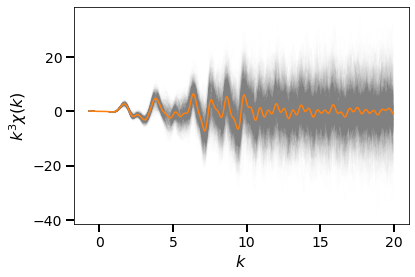

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
avg_k = np.average(Data[:, :, 0], axis=0)
avg_chi_of_k = np.average(Data[:, :, 1], axis=0)
std_of_chi = np.std(Data[:, :, 1], axis=0, ddof=1)

N = len(std_of_chi)

for run in Data:
    plt.plot(run[:, 0], run[:, 0]**kweight * run[:, 1], '-', c='gray', alpha=0.003)
plt.plot(avg_k, avg_k**kweight * avg_chi_of_k, '-', c=plt.cm.tab20(2), alpha=1.)

show_std_err_of_mean = False
if show_std_err_of_mean:
    #ax.fill_between(avg_k, avg_k**kweight * (avg_chi_of_k + 3 * std_of_chi / np.sqrt(N)),
    #                avg_k**kweight * (avg_chi_of_k - 3 * std_of_chi / np.sqrt(N)),
    #                color=plt.cm.tab20(0), alpha=0.9)
    ax.plot(avg_k, avg_k**kweight * (avg_chi_of_k + 3 * std_of_chi / np.sqrt(N)), '--', c=plt.cm.tab10(1))
    ax.plot(avg_k, avg_k**kweight * (avg_chi_of_k - 3 * std_of_chi / np.sqrt(N)), '--', c=plt.cm.tab10(1))
    plt.xlim(12, 17)
    plt.ylim(-1.5, 1.5)

ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$k^' + f'{kweight}' + '\chi(k)$', fontsize=16)
plt.savefig('Figures/chi_of_k.png', dpi=800, bbox_inches='tight')

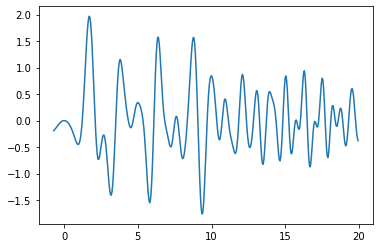

In [4]:
plt.plot(Data[0, :, 0], Data[0, :, 1] * Data[0, :, 0]**2)

In [5]:
dk = Data[0, 1, 0] - Data[0, 0, 0]
chi_k_weighted = Data[:, :, 1] * Data[:, :, 0]**kweight
nfft = 2048

def fourier_transform(chi, dk, nfft=2048):
    window = hann(len(chi))
    chi_processed = np.zeros(nfft, dtype='complex128')
    chi_processed[:len(chi)] = window * chi
    fx = dk / np.sqrt(np.pi) * fft(chi_processed)[:int(nfft / 2)]
    return np.sqrt(fx.real**2 + fx.imag**2)

def inverse_fourier_transform(chi_r, dk, nfft=2048):
    chi_processed = np.zeros(nfft, dtype='complex128')
    chi_processed[:len(chi_r)] = chi_r
    return 4 * np.sqrt(np.pi) / dk * ifft(chi_processed)[:int(nfft / 2)]

g_of_r = np.array([fourier_transform(chi_k_weighted[i], dk, nfft=nfft) for i in range(len(chi_k_weighted))])
avg_g_of_r = fourier_transform(avg_chi_of_k * avg_k**kweight, dk, nfft=nfft)

In [6]:
g_of_r.shape

(839, 1024)

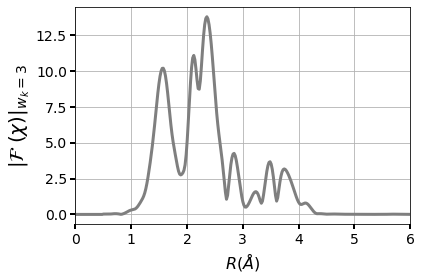

In [7]:
N = g_of_r.shape[1]

R = fftfreq(N, dk)
Rshift = 0.5
x = fftshift(R) + Rshift

fig, ax = plt.subplots(figsize=(6, 4))
for i in range(g_of_r.shape[0]):
    plt.plot(x, fftshift(g_of_r[i]), linewidth=3, c=plt.cm.tab20(14), alpha=1)
    break
#plt.plot(x, fftshift(np.average(g_of_r, axis=0)), linewidth=3, c=plt.cm.tab20(2))
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
plt.grid()
ax.set_xlabel("$R (\AA) $", fontsize=16)
ax.set_ylabel("$\|\mathcal{F}\;(\chi) \|_{w_k=" + f'{kweight}' + "}$", fontsize=20)
plt.xlim(0, 6)
plt.show()

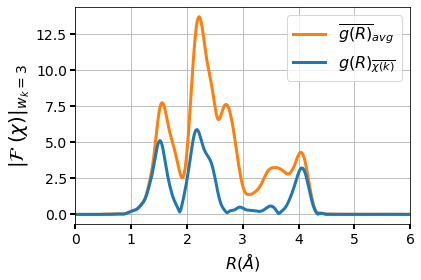

In [8]:
i = 3
fig, ax = plt.subplots(figsize=(6, 4))
#plt.plot(x, fftshift(g_of_r[i]), linewidth=3, c=plt.cm.tab20(14), alpha=0.7,
#         label=f'Run {i + 1}')
plt.plot(x, fftshift(np.average(g_of_r, axis=0)), linewidth=3, c=plt.cm.tab20(2),
         label='$\overline{g(R)}_{avg}$')
plt.plot(x, fftshift(avg_g_of_r), linewidth=3, c=plt.cm.tab20(0),
        label='$g(R)_{\overline{\chi(k)}}$')
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
plt.grid()
ax.set_xlabel("$R (\AA)$", fontsize=16)
ax.set_ylabel("$\|\mathcal{F}\;(\chi) \|_{w_k=" + f'{kweight}' + "}$", fontsize=20)
plt.xlim(0, 6)
plt.legend(fontsize=16)
plt.show()

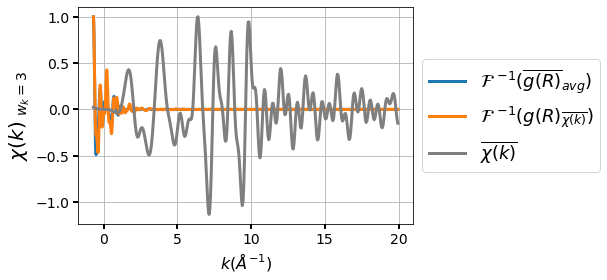

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

k_rescaled = np.linspace(min(avg_k), max(avg_k), int(nfft / 2))

y1 = inverse_fourier_transform(np.average(g_of_r, axis=0), dk)
plt.plot(k_rescaled, y1.real / np.max(y1.real), linewidth=3, label='$\mathcal{F}\;^{-1}(\overline{g(R)}_{avg})$')

y2 = inverse_fourier_transform(avg_g_of_r, dk)
plt.plot(k_rescaled, y2.real / np.max(y2.real), linewidth=3, label='$\mathcal{F}\;^{-1}(g(R)_{\overline{\chi(k)}})$')

y = avg_k**kweight * avg_chi_of_k
plt.plot(avg_k, y / np.max(y), c=plt.cm.tab20(14), linewidth=3, label='$\overline{\chi(k)}$')

plt.grid()
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
ax.set_xlabel("$k (\AA^{-1})$", fontsize=16)
ax.set_ylabel("$\chi(k)\; _{w_k=" + f'{kweight}' + "}$", fontsize=20)
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Tasks

1. How to remove donuts if they're numerical artifacts?

2. Re vs Imag instead of mod of wavelets?

3. g(r) only? Just FFT filter high freq to only keep first shell --> Make movie

4. Scree on R bands (i.e. first shell)

### Hypotheses:

1. features with physical meaning?: chi(k) g(R), w(k, R)

2. global featurization vs shell driven?

3. See phonons?

4. info about dsitortion is retained?

Diffuse x-ray scattering in book. X-ray diffraction vs EXAFS affects of thermal disorder?

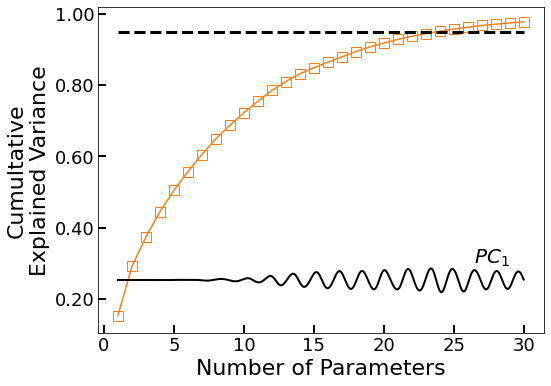

In [10]:
make_scree_plot(Data[:, :, 1] * Data[:, :, 0]**kweight, n=30, mod=5)

In [11]:
Moduli = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    modulus = np.flip(modulus, axis=0)  # put origin in bottom left (not top left)
    Moduli.append(modulus)
Moduli = np.array(Moduli)
print(Moduli.shape)
max_mod = np.max(Moduli)

(839, 261, 414)


In [63]:
data = Moduli.reshape(len(Moduli), -1)

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_components = pca.fit_transform(data)

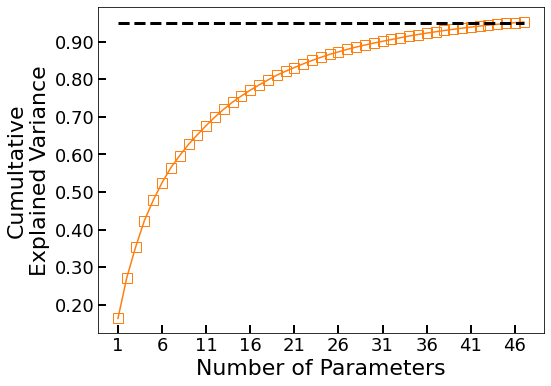

In [64]:
n = 47
threshold = 0.95
mod = 5
x = np.arange(n) + 1
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, cdf, 's-', markersize=10, fillstyle='none', color=plt.cm.tab20(2))

ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

xticks = np.arange(0, n, mod) + 1
plt.xticks(xticks, fontsize=18)
plt.yticks(fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)

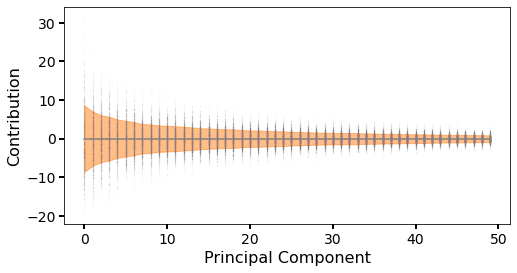

In [65]:
x = np.arange(pca_components.shape[1])
avg_coeffs = np.average(pca_components, axis=0)
std = np.std(pca_components, axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
for pc in pca_components:
    plt.plot(x, pc, '.', markersize=0.5, c='gray', alpha=0.1)
plt.plot(x, avg_coeffs, '-', c='gray')
ax.fill_between(x, avg_coeffs + std, avg_coeffs - std, color=plt.cm.tab20(2), alpha=0.5)
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Contribution', fontsize=16)
plt.show()

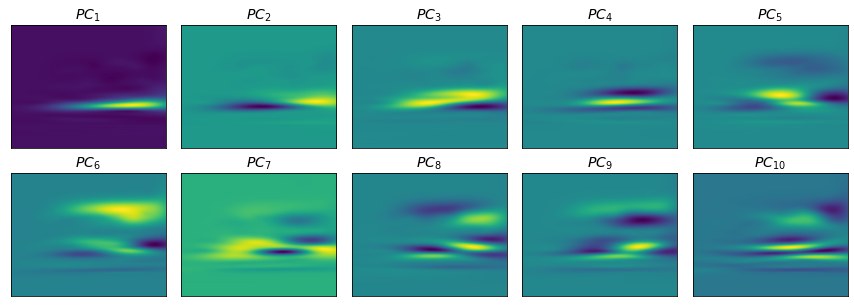

In [66]:
n = 5
fig, axes = plt.subplots(figsize=(3 * n, 5), nrows=2, ncols=n)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

extent = [0, 1, 0, 1]

for i in range(n):
    pc_img_1 = pca.components_[i].reshape(Moduli.shape[1], -1)
    pc_img_2 = pca.components_[i + n].reshape(Moduli.shape[1], -1)
    axes[0, i].imshow(pc_img_1, extent=extent, aspect='auto')
    axes[1, i].imshow(pc_img_2, extent=extent, aspect='auto')
    for j, ax in enumerate(axes[:, i]):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('$PC_{' + f'{i + j*n + 1}' + '}$', fontsize=14)

plt.show()

In [67]:
n_neighbors = 15
min_dist = 0.3
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

In [68]:
reduced_space.shape

(839, 2)

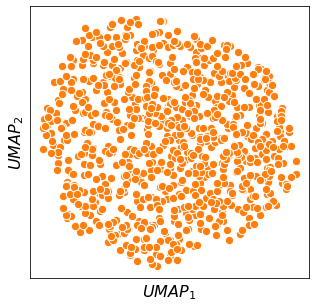

In [69]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
            color=plt.cm.tab20(2), edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)
plt.show()

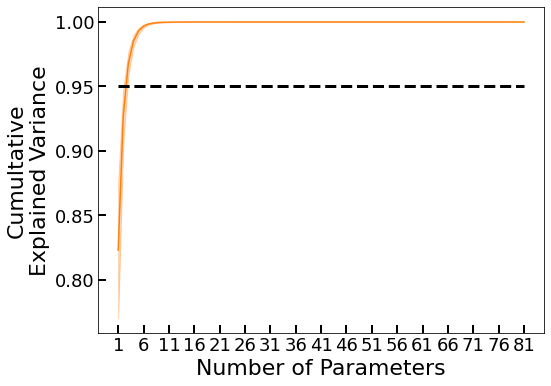

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
n = 5
threshold = 0.95
mod = 5

cdfs = []
for data in Moduli[:50]:
    pca = PCA()
    pca_components = pca.fit_transform(data)
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    cdfs.append(cdf)
cdfs = np.array(cdfs)

x = np.arange(n) + 1
avg = np.average(cdfs, axis=0)
std = np.std(cdfs, axis=0)
ax.plot(x, avg, '-', markersize=10, fillstyle='none', color=plt.cm.tab20(2), alpha=1.)
ax.fill_between(x, avg + std, avg - std, color=plt.cm.tab20(2), alpha=0.3)

ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)
   
xticks = np.arange(0, n, mod) + 1
plt.xticks(xticks, fontsize=18)
plt.yticks(fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)

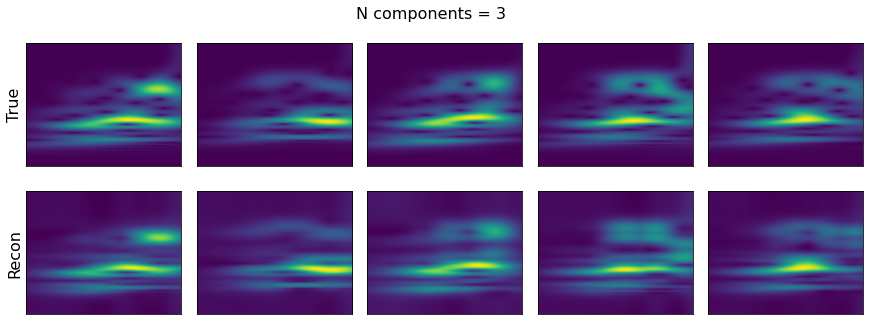

In [77]:
n = 5
n_components = 3
fig, axes = plt.subplots(figsize=(3 * n, 5), nrows=2, ncols=n)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

threshold = 0.9
extent = [0, 1, 0, 1]

for i, data in enumerate(Moduli[:n]):
    pca = PCA(n_components=n_components)
    recon = pca.inverse_transform(pca.fit_transform(data))
    axes[0, i].imshow(data, extent=extent, aspect='auto')
    axes[1, i].imshow(recon, extent=extent, aspect='auto')
    for ax in axes[:, i]:
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('True', fontsize=16)
axes[1, 0].set_ylabel('Recon', fontsize=16)
plt.suptitle(f'N components = {n_components}', fontsize=16)
plt.show()

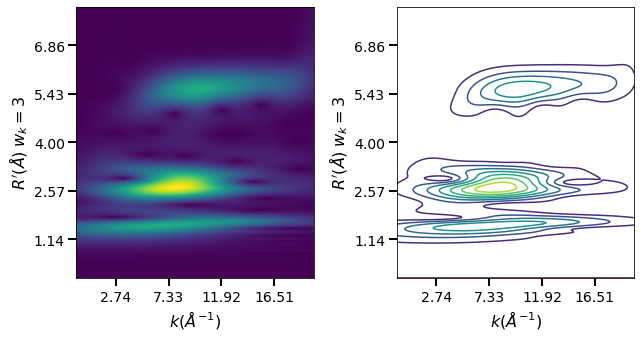

In [12]:
rmax_out = 8
wavelet = wavelet_transform.cauchy_wavelet(avg_k, chi=avg_chi_of_k, rmax_out=rmax_out, kweight=kweight)
modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2) / max_mod

extent = [0, 1, 0, 1]

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=0.35)

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(modulus, origin='lower', extent=extent, aspect='auto')
    else:
        ax.contour(modulus, extent=extent)

    ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
    set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
    set_axes(ax, 0, rmax_out, nticks=5, axis='y')
    ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
    ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)

plt.savefig('Figures/avg_wavelet_and_contour.png', dpi=800, bbox_inches='tight')

In [13]:
def plot_contours(i):
    fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
    plt.subplots_adjust(wspace=0.35)

    for j, ax in enumerate(axes): 
        if j == 0:
            ax.imshow(Moduli[i], origin='upper', extent=extent)
        else:
            ax.contour(Moduli[i], origin='upper', extent=extent)

        ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
        set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
        set_axes(ax, 0, rmax_out, nticks=5, axis='y')
        ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
        ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)
    
    plt.show()
        
slider = IntSlider(min=0, max=len(Moduli), step=10, value=0, layout=widgets.Layout(width='70%'))
interactive(plot_contours, i=slider)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='70%'), max=839, step=10), Outpu…

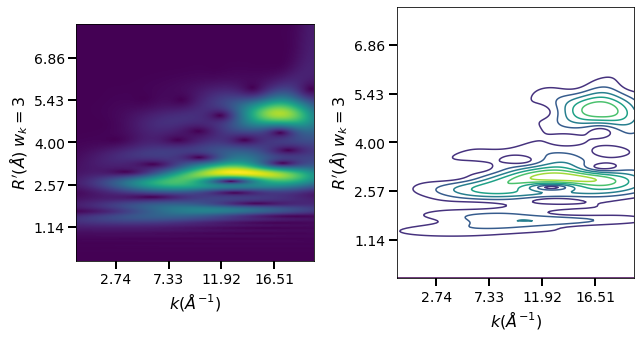

In [18]:
def animate(i):
    for j, ax in enumerate(axes): 
        ax.clear()
        if j == 0:
            ax.imshow(Moduli[i], origin='upper', extent=extent)
        else:
            ax.contour(Moduli[i], origin='upper', extent=extent)

        ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
        set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
        set_axes(ax, 0, rmax_out, nticks=5, axis='y')
        ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
        ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)
        
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=0.35)
ani = FuncAnimation(fig, animate, interval=5, frames=50, blit=False)    
ani.save("wavelet_contours.gif", dpi=800, writer=PillowWriter(fps=3))

In [26]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [27]:
i = 0
print("RMSE: ", rmse(Moduli[i]/255., Moduli[i + 1]/255.))

RMSE:  0.00031992381211767184


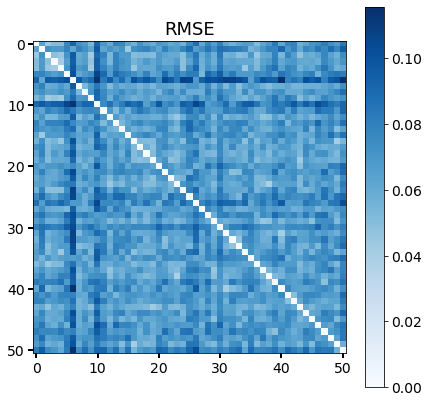

In [44]:
N = len(Moduli)
N = 51
mod = 10
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = rmse(Moduli[i] / max_mod, Moduli[j] / max_mod)
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score
        

fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest')
plt.title('RMSE', fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
ax.set_yticks(np.arange(0, N, mod))
ax.set_xticks(np.arange(0, N, mod))
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
plt.show()

In [47]:
images = []
mods = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    modulus = np.flip(modulus, axis=0)  # put origin in bottom left (not top left)
    img = Image.fromarray(np.uint8(plt.cm.viridis(modulus / max_mod) * 255))
    images.append(img)
    mods.append(modulus)

frame_one = images[0]
frame_one.save("wavelets_long_k_cubed.gif", format="GIF", append_images=images,
               save_all=True, duration=250, loop=0)  # duration in ms